
## CQF Final Project: Long/Short Trading Strategy Design & Backtest
### Alexys Pereira

In [2]:
import os
import sys
sys.path.append(os.getcwd())
from pairs_trading import PairTradingBacktest,TradeAnalyzer
from cointegration import OLS, ADF, EngleGranger

import glob
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web
import itertools
import datetime as dt
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy import stats
pd.set_option("display.max_column",999)

In [3]:
def compute_risk_metrics(backtest_tbl,historical_tbl=None):
   
    trade_analysis=[]
    for i, g in backtest_tbl.groupby("bounds_id"):
        historical_series = historical_tbl.query(f"bounds_id=={i}").set_index("day")['trade_daily_return'].dropna() if historical_tbl is not None else historical_tbl
        bounds_id = g.bounds_id.max()
        zscore=g.zscore.max()
        return_series = g['trade_daily_return'].copy()
        return_series.index=g.day
        return_series=return_series[return_series.notnull()]    
        analyzer = TradeAnalyzer(return_series, "SPY",historical_returns=historical_series)
        analyzer.generate_analysis()
        analyzer.summary_table()   
        trade_analysis.append([bounds_id,zscore,analyzer])
    summary = pd.concat([ a.summary_table().assign(strategy_id=b, zscore=z) for b,z,a in trade_analysis])
    summary.head()
    summary['Strategy']="Z-Score = " + summary.zscore.astype(str)
    summary= summary.pivot(columns='Strategy',values=['Value (%)'],index='Metric')
    summary=summary.reindex(index=['Annual Return','Annual Vol','Cumulative Return','Alpha (Annual)','Sharpe','Beta','Beta P-Value','Alpha P-Value','Max Drawdown','1-Day VaR 99%','10-Day VaR 99%','1-Day ES 99%','10-Day ES 99%'])
    
    trade_analysis=pd.DataFrame(trade_analysis,columns=['bounds_id','zscore','analyzer'])
    return summary,trade_analysis

In [4]:
tickers= [
            'CADUSD=X',
            'BZ=F',
            'RY.TO',
            'TD.TO',
            "JPYUSD=X",
            'GC=F',        

]


labels_ticker = ['CAD/USD', 
                 'Crude Oil Future',
                 'RBC',
                 'TD Bank',
                 'JPY/USD',
                 'Gold Futures',
                ]

pairs =[
        ['RY.TO','TD.TO'],
        ['CADUSD=X','BZ=F',],
        ["JPYUSD=X",'GC=F'],
       ]



In [5]:
labels_ticker = dict(zip(tickers,labels_ticker))


In [36]:

data = web.DataReader(tickers,'yahoo',start= '2008-01-01', end='2022-06-30')


In [37]:
data = data['Adj Close'].reset_index()

data.head()

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
0,2008-01-01,1.006847,NaN,NaN,NaN,0.008943,NaN
1,2008-01-02,1.005632,97.839996,27.910959,19.577118,0.009152,857.000000
2,2008-01-03,1.011327,97.599998,27.660778,19.467907,0.009132,866.400024
3,2008-01-04,1.001202,96.790001,27.466171,19.289722,0.009206,863.099976
4,2008-01-07,0.994530,94.389999,27.282686,18.870129,0.009155,859.599976


In [38]:
data.to_csv("data.csv",index=False)

In [39]:
data = data.fillna(method='ffill').dropna()
data.head()

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
1,2008-01-02,1.005632,97.839996,27.910959,19.577118,0.009152,857.000000
2,2008-01-03,1.011327,97.599998,27.660778,19.467907,0.009132,866.400024
3,2008-01-04,1.001202,96.790001,27.466171,19.289722,0.009206,863.099976
4,2008-01-07,0.994530,94.389999,27.282686,18.870129,0.009155,859.599976
5,2008-01-08,0.995223,95.540001,27.243767,18.717808,0.009289,878.000000


In [40]:
data[tickers]=data[tickers]/data.loc[0:1,tickers].values

train= data.loc[data.Date.between('2010-01-01','2016-12-31'),:].copy()
valid= data.loc[data.Date.between('2017-02-01','2019-02-01'),:].copy()
test= data.loc[data.Date.between('2019-03-01','2020-02-01'),:].copy()

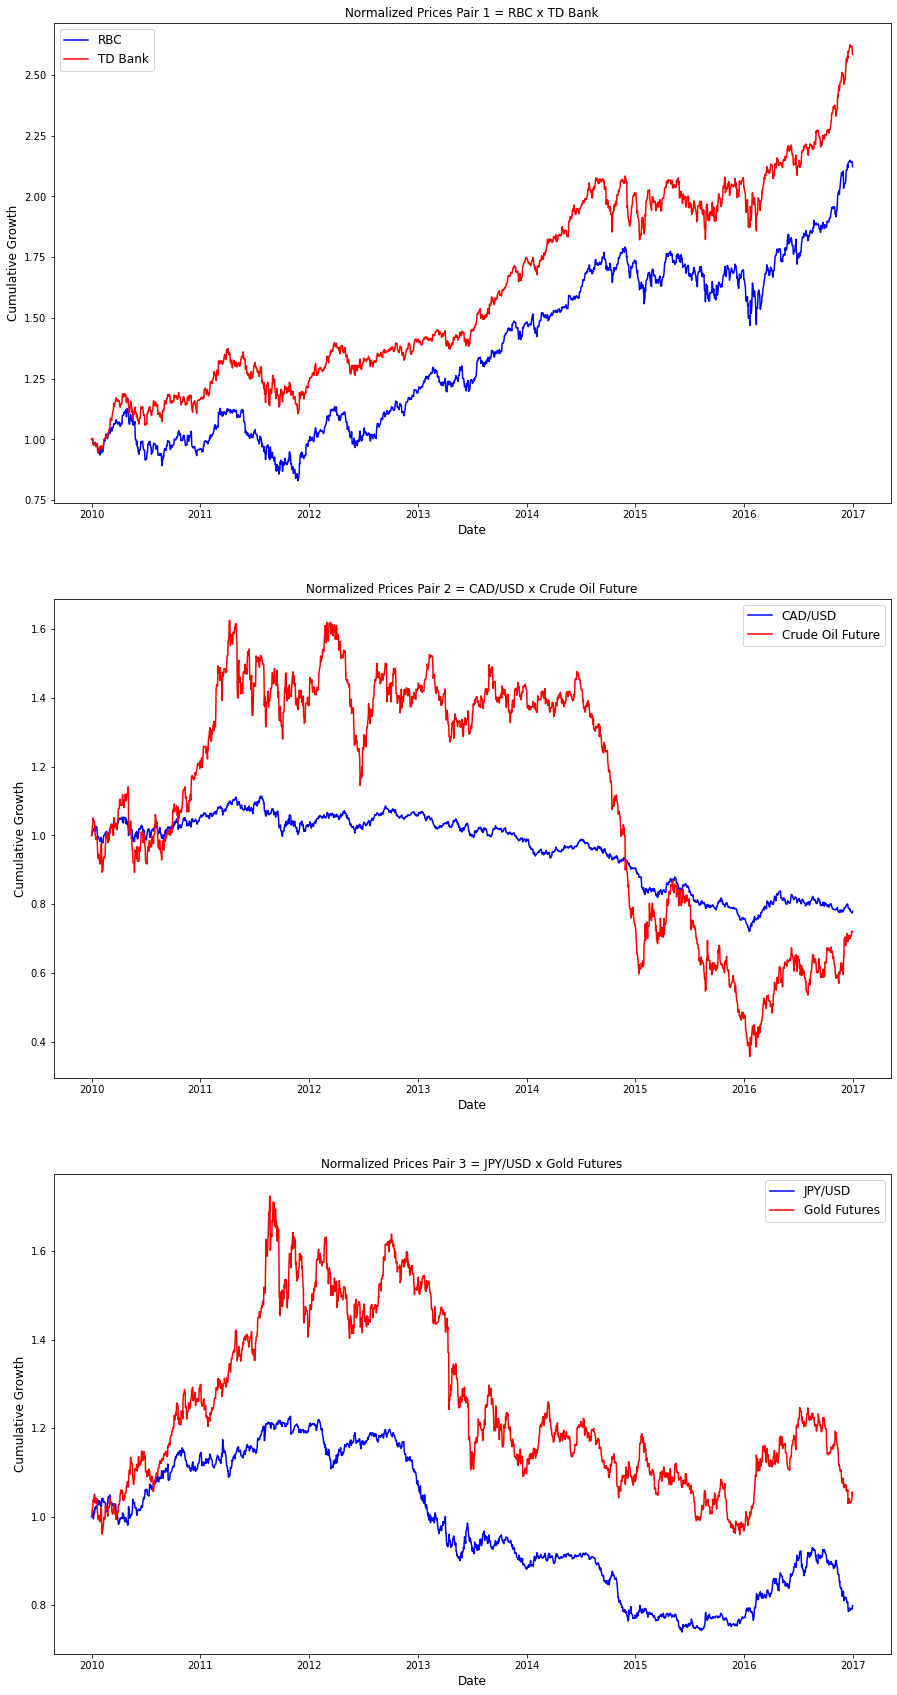

In [41]:
fig, ax = plt.subplots(nrows=len(pairs),ncols=1, figsize=(15,30),squeeze=True,)

for i, (T1,T2) in enumerate(pairs,1):
    corr = np.corrcoef(train[T1].values,train[T2].values,rowvar=False).min()
    ax[i-1].plot( train['Date'],train[T1]/train[T1].values[0],color='blue',label=labels_ticker[T1])
    ax[i-1].plot( train['Date'],train[T2]/train[T2].values[0],color='red',label=labels_ticker[T2])
    ax[i-1].set_title(f'Normalized Prices Pair {i} = {labels_ticker[T1]} x {labels_ticker[T2]}',fontsize=12)
    ax[i-1].set_xlabel(f'Date',fontsize=12)
    ax[i-1].set_ylabel(f'Cumulative Growth',fontsize=12)   
    ax[i-1].legend(loc='best',fontsize=12)
    ax[i-1].annotate(f"Correlation = {corr:.2f}",
                        xy=(dt.datetime(2017,8,10),1.3),
                        xytext=(dt.datetime(2016,8,10),1.3),fontsize=12)
    
plt.show()

### Pair 1: TD.TO x RY.TO

#### Engle Granger Fitting

In [42]:
eg = EngleGranger()

In [43]:
eg.fit(train['TD.TO'],train['RY.TO'])

In [44]:
eg.compare_ols

Variable  RY.TO                          Variable  TD.TO          \
Statistic             Beta P-Value     SE   T-Stat             Beta P-Value   
0          Constant  0.027   0.000  0.006    4.168  Constant  0.022   0.001   
1             TD.TO  0.972   0.000  0.004  262.293     RY.TO  0.999   0.000   

                           
Statistic     SE   T-Stat  
0          0.007    3.308  
1          0.004  262.293

In [45]:
eg.compare_adf

,Equation 1:,RY.TO = TD.TO + Constant,,Equation 2:,TD.TO = RY.TO + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.623512,,,-3.661117,,
P-Value (MacKinnon),0.005327,,,0.004695,,
Optimal Lag,0,,,0,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Reject,Reject,Reject,Reject,Reject,Reject
Stationary/Non Stationary,Stationary,Stationary,Stationary,Stationary,Stationary,Stationary


In [46]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.756   0.000  0.013  60.013
Residual(-1)  -0.008   0.002  0.003  -3.090

In [47]:
eg.ou_process_summary.style.set_caption("Table 4: OU Process")

,Value
OU Process Parameters,
$\mu_e$,0.012476
Half-Life (days),63.386811
$\sigma$,0.181998
$\theta$,2.755669


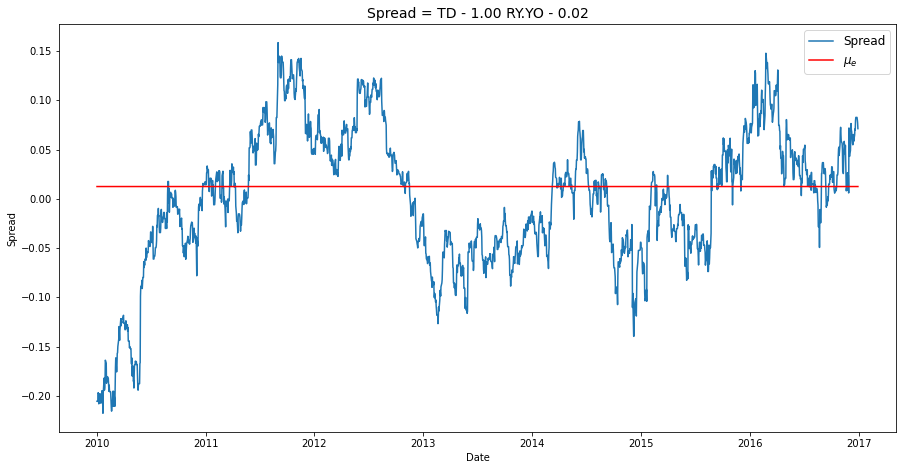

In [49]:
ou_parameters= eg.ou_process_params

coint_params= eg.cointegration_params

spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = TD - {coint_params[1]:.2f} RY.YO - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



#### Backtesting Pair Trading

In [50]:
z= [0.2,0.3,0.4,0.5,0.6,0.7]
z=np.array(z)

In [51]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['RY.TO'],
                             train['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [52]:
ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['RY.TO'],
                             valid['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [53]:
train_signals  = ptback_train.backtest()
valid_signals  = ptback_valid.backtest()


In [54]:
ptback_train.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,17.0,6.481130,9.853551,48.213229,115.764706,1968
1,2,0.3,13.0,7.292863,9.870945,50.312612,140.230769,1823
2,3,0.4,7.0,9.453221,10.171792,53.415274,214.428571,1501
3,4,0.5,6.0,10.850229,10.008619,56.136170,227.833333,1367
4,5,0.6,5.0,11.716783,10.046198,55.083011,251.800000,1259
5,6,0.7,5.0,13.217607,9.857449,57.724262,231.800000,1159


In [55]:
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,6.0,1.621062,8.235470,3.406881,107.166667,643
1,2,0.3,5.0,1.313609,8.219729,2.665739,123.800000,619
2,3,0.4,5.0,2.997742,8.269963,5.923826,119.200000,596
3,4,0.5,4.0,3.065424,8.258262,5.843676,143.750000,575
4,5,0.6,3.0,1.840279,8.469151,3.138139,173.333333,520
5,6,0.7,2.0,0.078758,8.351505,0.130985,255.500000,511


In [56]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results)

In [57]:
summary_train

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return          6.481130      7.292863      9.453221     10.850229   
Annual Vol             9.853551      9.870945     10.171792     10.008619   
Cumulative Return     48.213229     50.312612     53.415274     56.136170   
Alpha (Annual)         6.738126      7.584552      9.597577     10.797027   
Sharpe                33.189171     40.913678     59.102501     73.061698   
Beta                   5.546498      6.593761      7.071751     10.418946   
Beta P-Value           0.248222      0.046732      0.057476      0.000125   
Alpha P-Value          8.652699      6.384011      3.947277      2.371762   
Max Drawdown          11.403240     10.066783      9.395367      7.732077   
1-Day VaR 99%          1.417154      1.416683      1.452740      1.423858   
10-Day VaR 99%         4.297873      4.275726      4.334836      4.209526   
1-Day ES 99%           1.627494      1.627394      1.669873      1.637508   
10-Day ES 99%          4.963025      4.942053      5.021470      4.885146   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return         11.716783     13.217607  
Annual Vol            10.046198      9.857449  
Cumulative Return     55.083011     57.724262  
Alpha (Annual)        10.936048     12.628552  
Sharpe                80.248889     94.917091  
Beta                  10.369396      7.219800  
Beta P-Value           0.000533      0.255235  
Alpha P-Value          2.913570      1.399000  
Max Drawdown           7.732077      7.732077  
1-Day VaR 99%          1.426258      1.393376  
10-Day VaR 99%         4.195868      4.056184  
1-Day ES 99%           1.640710      1.603799  
10-Day ES 99%          4.874025      4.721599

In [58]:
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results.query("bounds_id<3"),
                                                          historical_tbl=ptback_train.back_test_results)

In [59]:
summary_valid

Value (%)              
Strategy          Z-Score = 0.2 Z-Score = 0.3
Metric                                       
Annual Return          1.621062      1.313609
Annual Vol             8.235470      8.219729
Cumulative Return      3.406881      2.665739
Alpha (Annual)         1.991959      1.770749
Sharpe               -11.015208    -14.762735
Beta                   3.667800      4.452626
Beta P-Value          36.271895     27.191074
Alpha P-Value         72.719356     75.983063
Max Drawdown           8.665799      7.866314
1-Day VaR 99%          1.199146      1.198046
10-Day VaR 99%         3.739174      3.743952
1-Day ES 99%           1.374945      1.373509
10-Day ES 99%          4.295100      4.298814

In [60]:
trade1 = trade_analysis_train.query("bounds_id==1")['analyzer'].values[0]


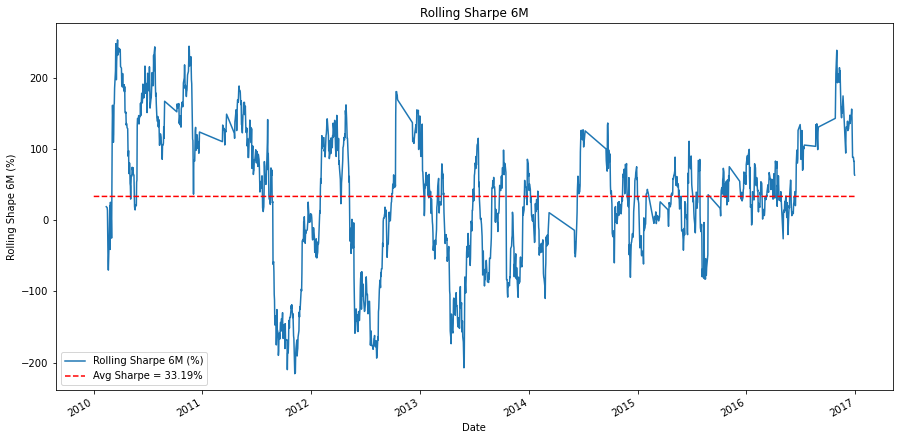

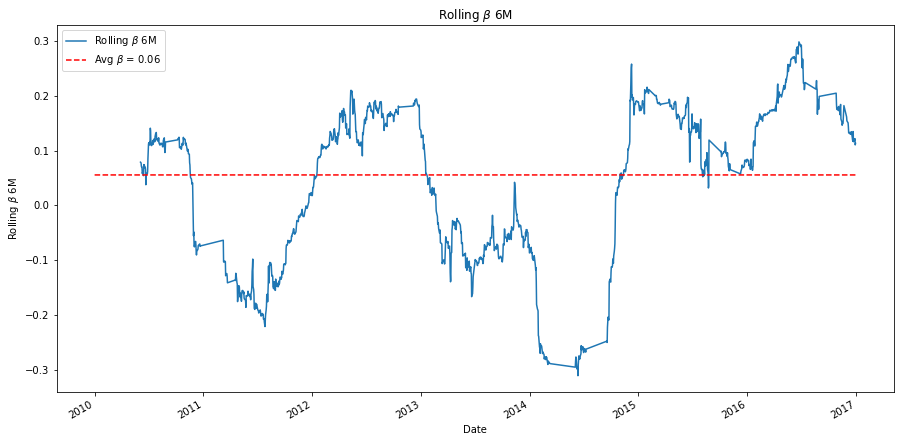

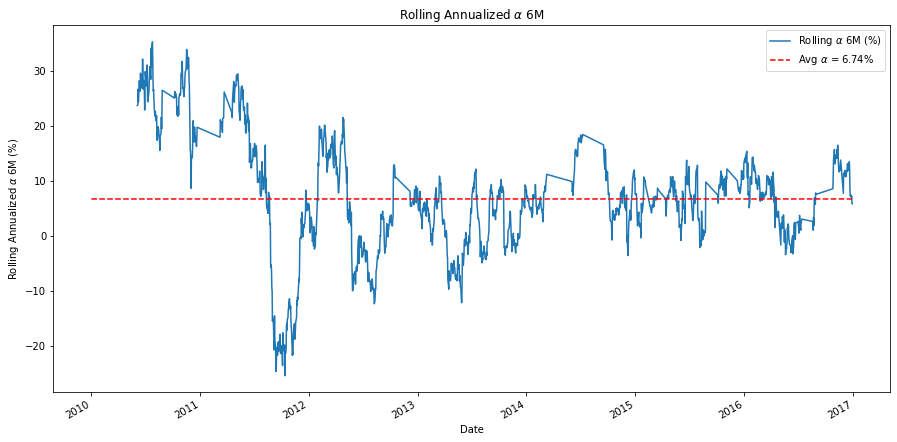

In [61]:
trade1plots=trade1.plots()

In [62]:
signals_valid  = ptback_valid.backtest()
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,6.0,1.621062,8.235470,3.406881,107.166667,643
1,2,0.3,5.0,1.313609,8.219729,2.665739,123.800000,619
2,3,0.4,5.0,2.997742,8.269963,5.923826,119.200000,596
3,4,0.5,4.0,3.065424,8.258262,5.843676,143.750000,575
4,5,0.6,3.0,1.840279,8.469151,3.138139,173.333333,520
5,6,0.7,2.0,0.078758,8.351505,0.130985,255.500000,511


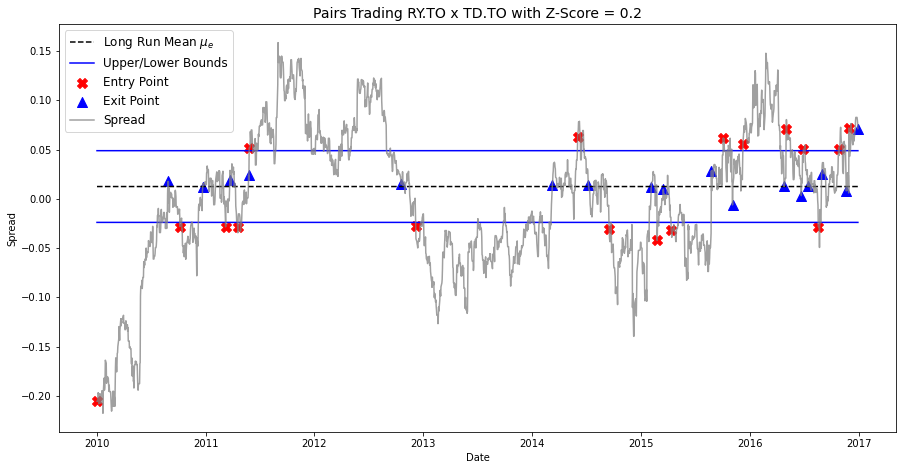

In [63]:
fig=ptback_train.plot_strategy(1)

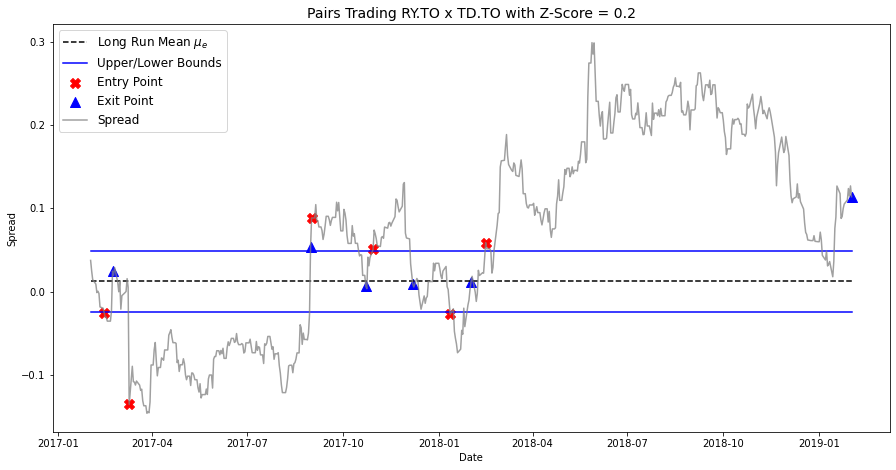

In [64]:
fig=ptback_valid.plot_strategy(1)

In [65]:
ptback_test = PairTradingBacktest(test.Date, 
                             test['RY.TO'],
                             test['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=[0.2],
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [66]:
ptback_test.backtest()

ptback_test.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,6.0,8.292086,8.423533,7.507579,46.333333,278


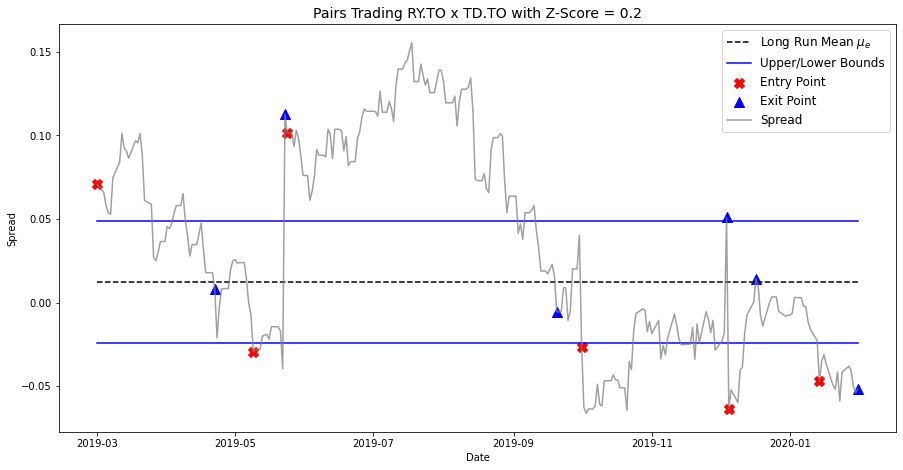

In [67]:
fig=ptback_test.plot_strategy(1)

In [68]:
summary_test,trade_analysis_test = compute_risk_metrics(ptback_test.back_test_results,
                                                          historical_tbl=ptback_valid.back_test_results)

In [69]:
summary_test.applymap('{:.2f}'.format)


,Value (%)
Strategy,Z-Score = 0.2
Metric,
Annual Return,8.29
Annual Vol,8.42
Cumulative Return,7.51
Alpha (Annual),8.17
Sharpe,63.59
Beta,1.99
Beta P-Value,79.83
Alpha P-Value,35.79


In [70]:
test_analyzer=trade_analysis_test.analyzer.values[0]

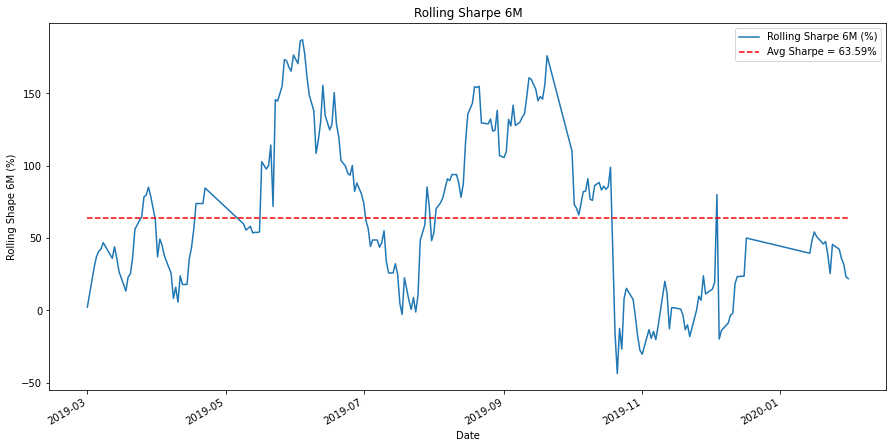

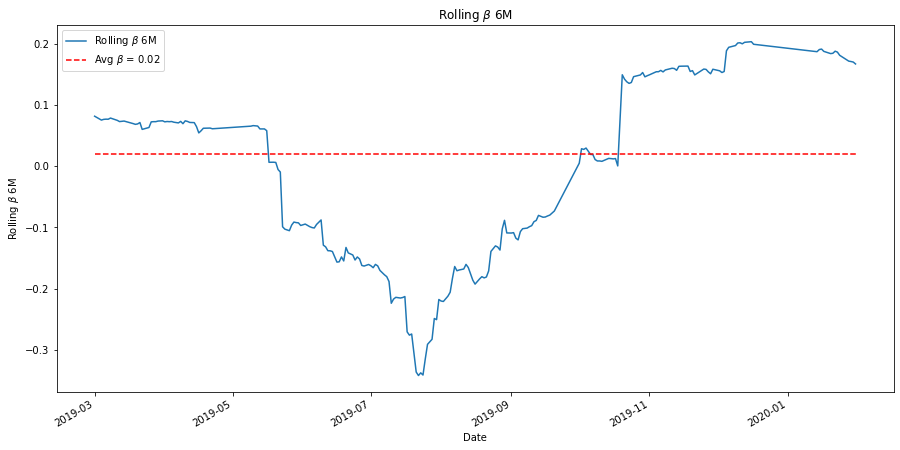

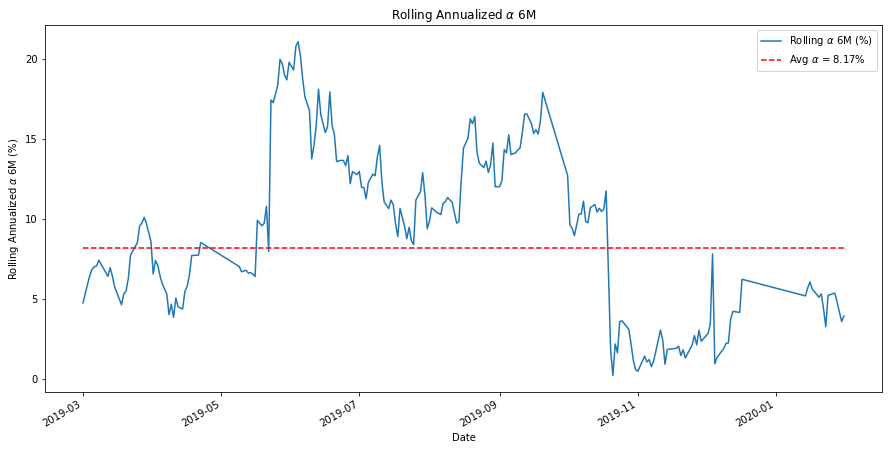

In [71]:
figs=test_analyzer.plots()

### Pair 2: JPYUSD x Gold Futures

#### Engle Granger Fitting

In [72]:
eg = EngleGranger()
eg.fit(train['JPYUSD=X'],train['GC=F'])

In [73]:

eg.compare_ols

Variable   GC=F                         Variable JPYUSD=X          \
Statistic             Beta P-Value     SE  T-Stat               Beta P-Value   
0          Constant  0.364   0.000  0.021  17.227  Constant    0.212   0.000   
1          JPYUSD=X  1.067   0.000  0.018  58.791      GC=F    0.590   0.000   

                          
Statistic     SE  T-Stat  
0          0.016  13.102  
1          0.010  58.791

In [74]:
eg.compare_adf

,Equation 1:,GC=F = JPYUSD=X + Constant,,Equation 2:,JPYUSD=X = GC=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.296319,,,-2.852289,,
P-Value (MacKinnon),0.015044,,,0.051184,,
Optimal Lag,24,,,25,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Not Reject,Reject,Reject,Not Reject,Not Reject,Reject
Stationary/Non Stationary,Non Stationary,Stationary,Stationary,Non Stationary,Non Stationary,Stationary


In [75]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.175   0.002  0.055   3.157
Residual(-1)  -0.010   0.000  0.003  -3.989

In [76]:

eg.best_ols.table_params_out

GC=F                       
Statistic   Beta P-Value     SE  T-Stat
Variable                               
Constant   0.364   0.000  0.021  17.227
JPYUSD=X   1.067   0.000  0.018  58.791

In [77]:
eg.ou_process_summary

,Value
OU Process Parameters,
$\mu_e$,0.016859
Half-Life (days),74.867917
$\sigma$,0.376355
$\theta$,2.333083


In [78]:
coint_params= eg.cointegration_params

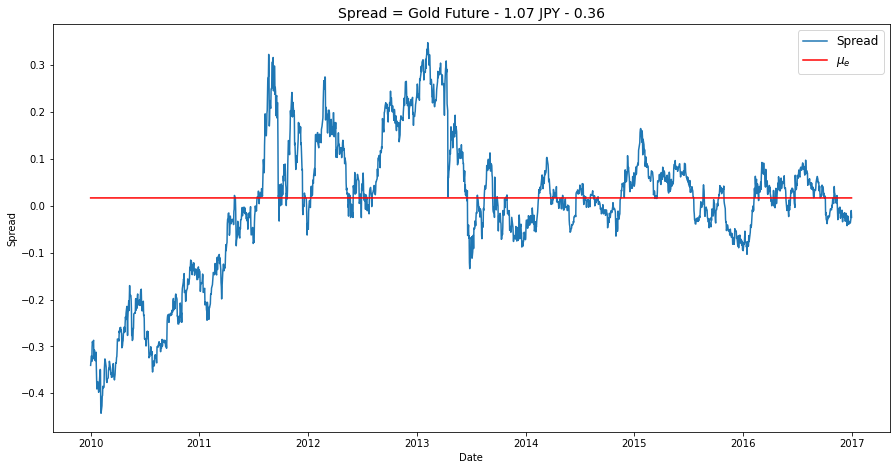

In [79]:
ou_parameters= eg.ou_process_params
coint_params= eg.cointegration_params
spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = Gold Future - {coint_params[1]:.2f} JPY - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



In [80]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['JPYUSD=X'],
                             train['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['JPYUSD=X'],
                             valid['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

In [81]:
train_backtest=ptback_train.backtest()
valid_backtest=ptback_valid.backtest()



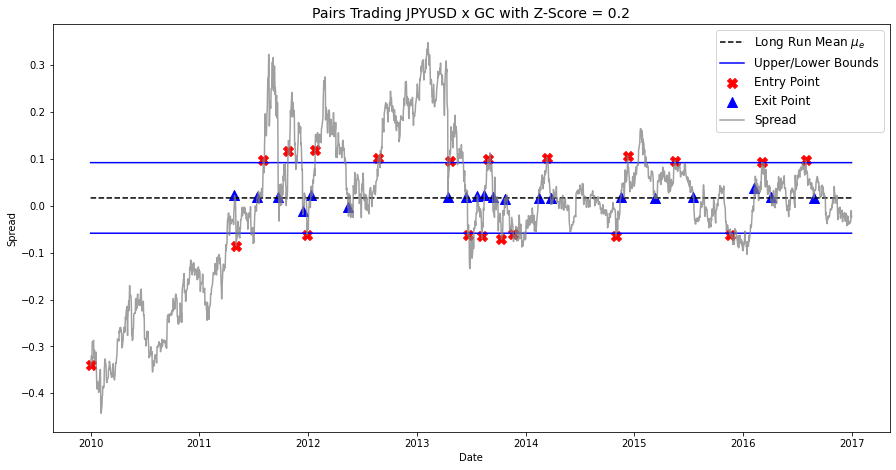

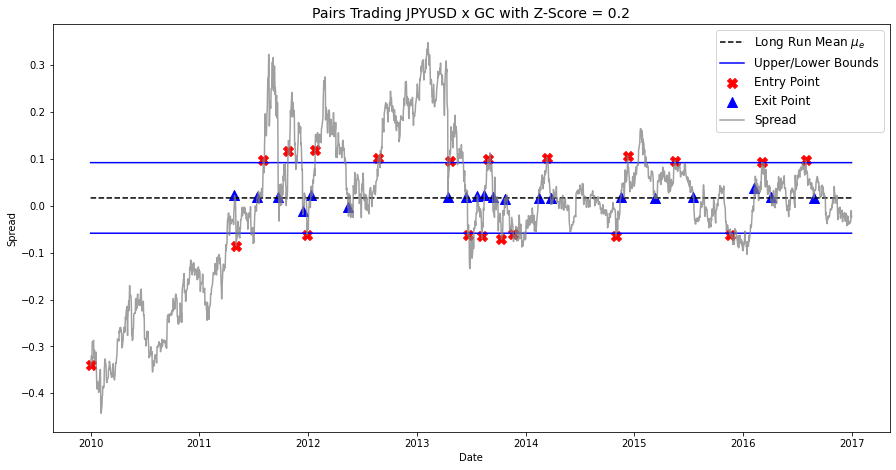

In [82]:
ptback_train.plot_strategy(1)


In [83]:
ptback_train.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,20.0,17.119293,19.961850,114.636778,77.000000,1540
1,2,0.3,9.0,19.558349,20.893796,80.358593,117.777778,1060
2,3,0.4,7.0,21.072362,20.907375,76.936272,136.000000,952
3,4,0.5,5.0,19.355636,20.793530,59.731227,170.000000,850
4,5,0.6,4.0,19.135783,20.708165,53.846638,198.000000,792
5,6,0.7,3.0,23.841656,21.598017,50.020984,202.000000,606


In [84]:
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,2.0,1.285198,10.414184,1.351944,166.0,332
1,2,0.3,1.0,5.737122,10.540438,5.713718,318.0,318


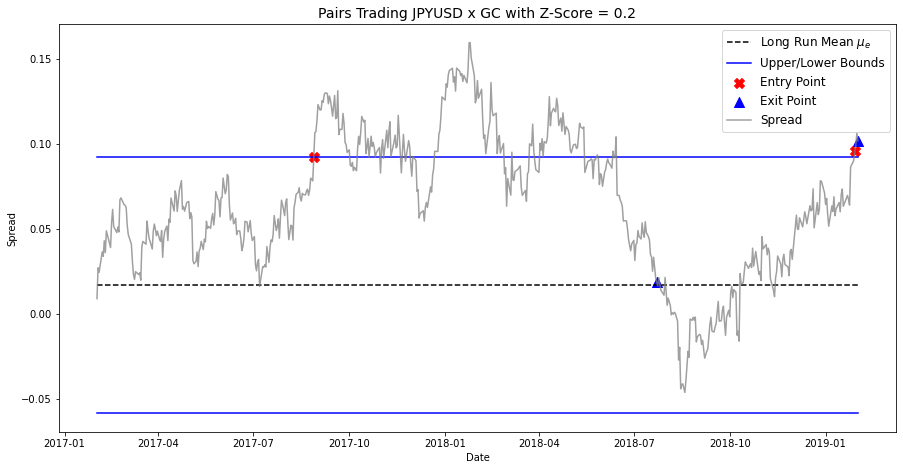

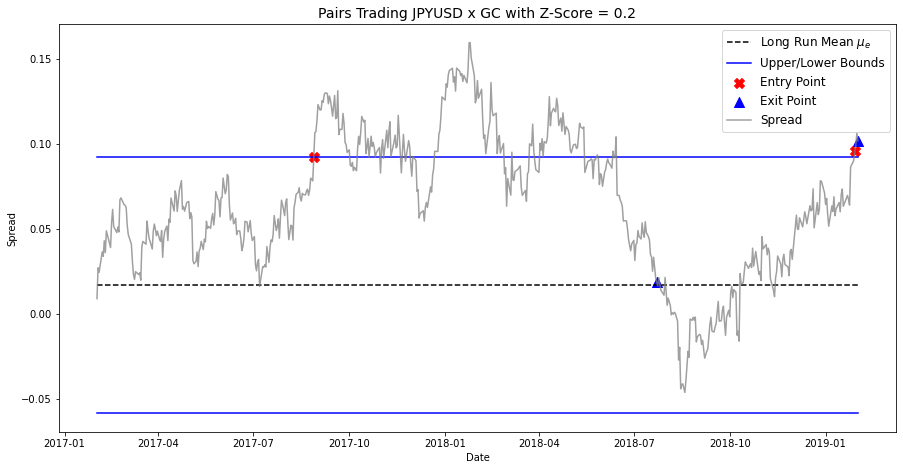

In [85]:
ptback_valid.plot_strategy(1)
